In [75]:
import warnings
warnings.filterwarnings(action="ignore")

import os

import numpy as np
import pandas as pd
pd.set_option("display.max_column", None)

import joblib
from scipy.stats import stats, zscore
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [76]:
# Load dataset
data = pd.read_csv("diabetes.csv")

# Display the shape of the dataset
print(data.shape)

# Display the first 5 rows
data.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [77]:
# Display the dataset information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [78]:
# Display statistical information about the dataset
data.describe().T.drop("count", axis="columns")

,mean,std,min,25%,50%,75%,max
Pregnancies,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [79]:
# Check for the presence of missing values
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

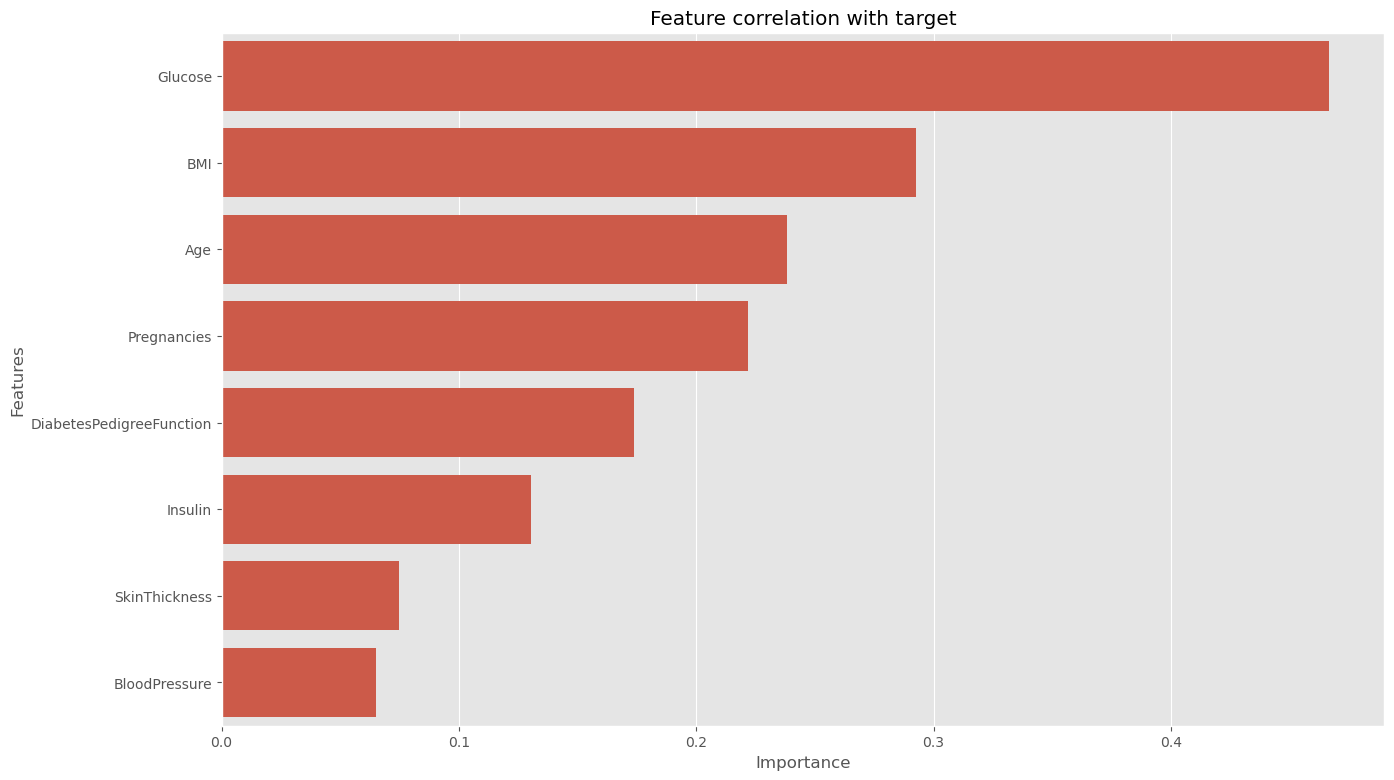

In [80]:
# Plot feature correlation with target
feat_corr = data.corr()["Outcome"][:-1].sort_values(ascending=False)
plt.figure(figsize=(15, 9))
barplot = sns.barplot(x=feat_corr.values, y=feat_corr.index)
barplot.set_xlabel("Importance")
barplot.set_ylabel("Features")
barplot.set_title("Feature correlation with target")
plt.show()

Target Distribution
65.10% = 0
34.90% = 1


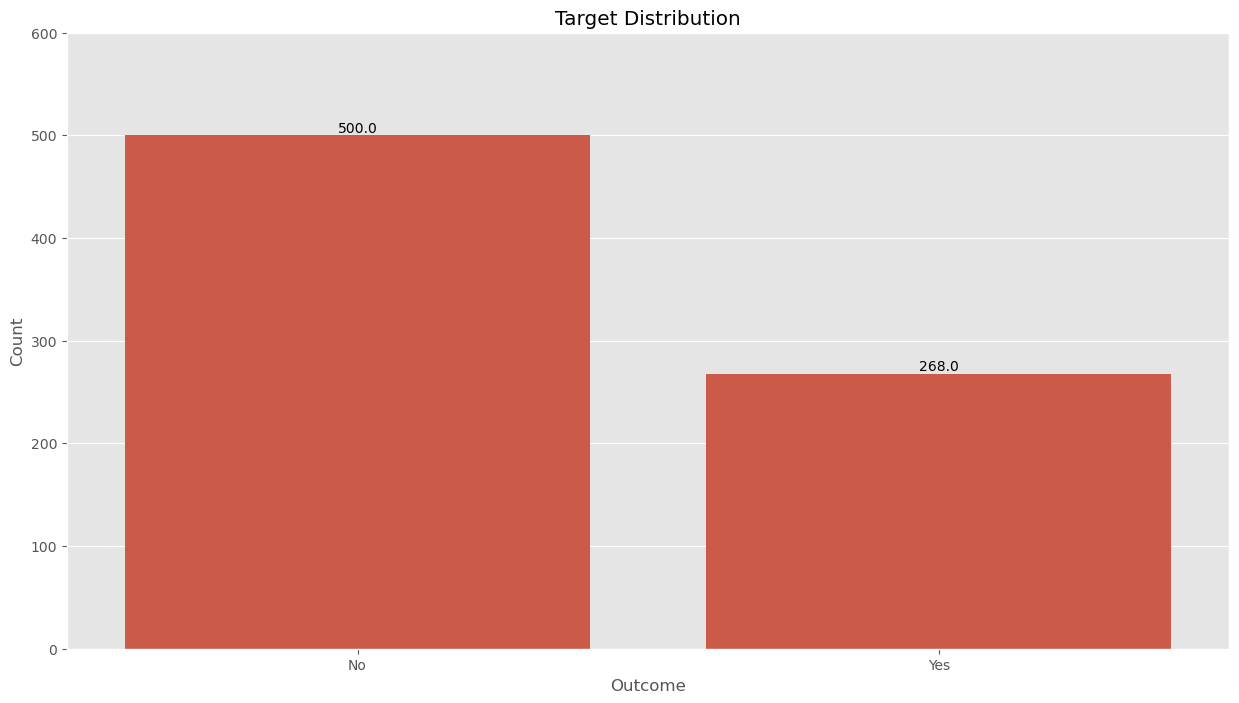

In [81]:
# Get the target distribution
percent_dict = data["Outcome"].value_counts().values[0]/data.shape[0] * 100
# Display the percent distribution of target variable
print(f"Target Distribution\n{percent_dict:.2f}% = 0\n{(100-percent_dict):.2f}% = 1")

# Plot the target distribution
target_distribution = data["Outcome"].value_counts()
plt.figure(figsize=(15, 8))
barplot = sns.barplot(x=target_distribution.index, y=target_distribution.values)

# Add text to the top of the bar
for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, f"{h}", ha="center", va="bottom")

# Set other parameters
barplot.set_ylim(bottom=0, top=600)
barplot.set_xticklabels(["No", "Yes"])
barplot.set_xlabel("Outcome")
barplot.set_ylabel("Count")
barplot.set_title("Target Distribution")
plt.show()

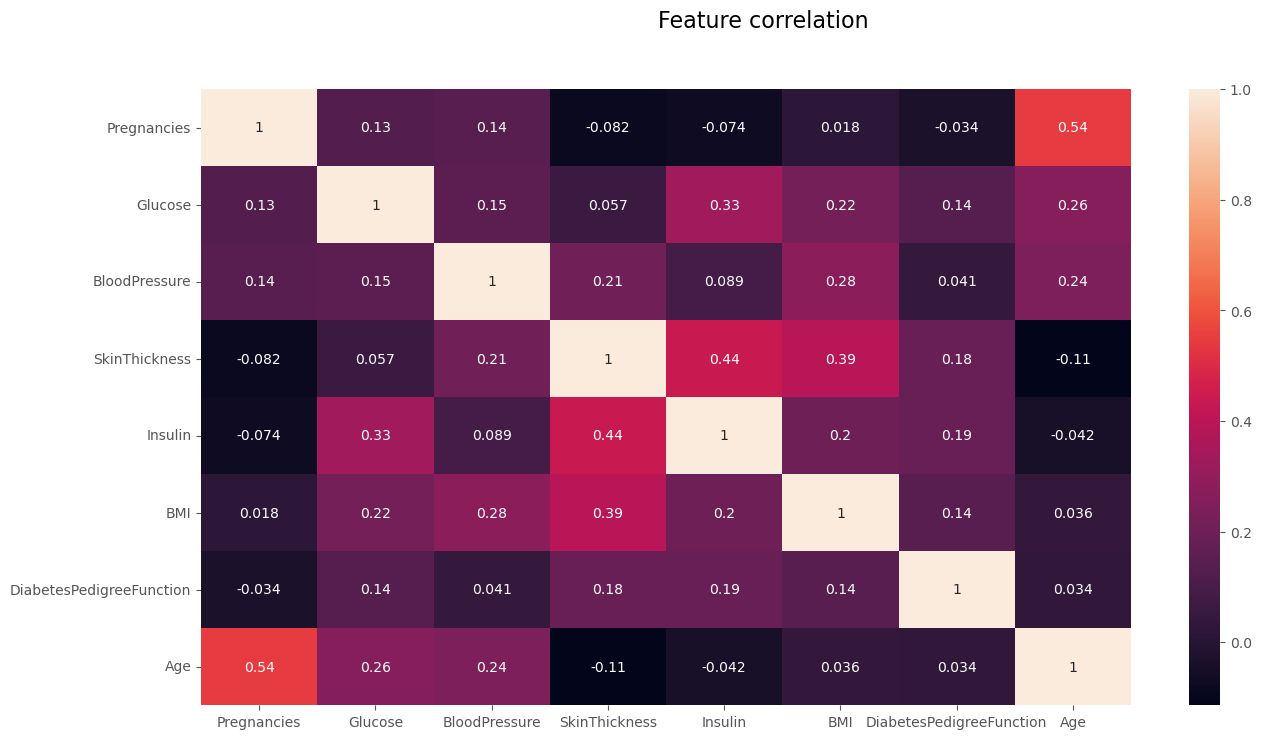

In [82]:
# Plot feature correlation matrix
plt.figure(figsize=(15, 8))
sns.heatmap(data.corr().iloc[:-1, :-1], annot=True)
# Add a subtitle to the plot
plt.suptitle("Feature correlation", fontsize=16)
plt.show()

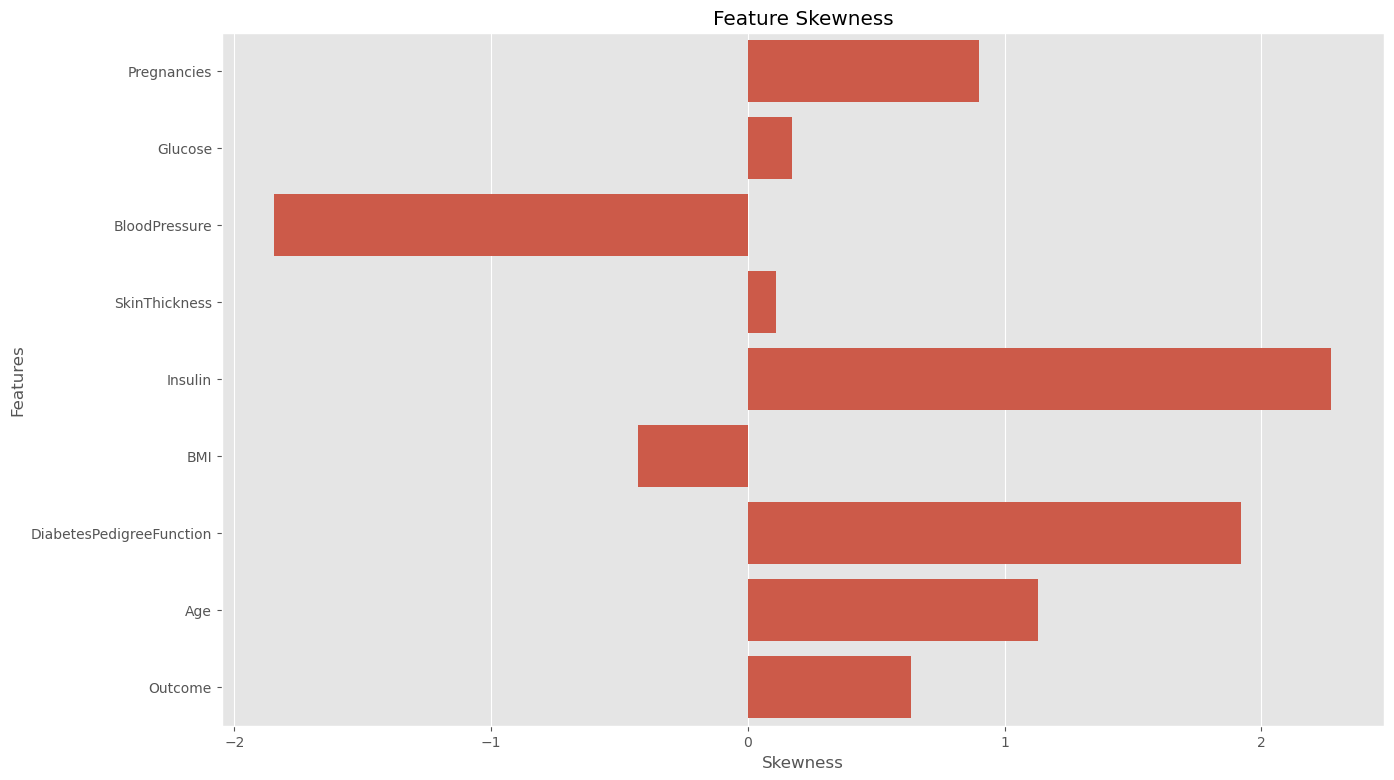

In [83]:
# Check for skewness
plt.figure(figsize=(15, 9))
barplot = sns.barplot(x=data.skew().values, y=data.skew().index)
barplot.set_title("Feature Skewness")
barplot.set_xlabel("Skewness")
barplot.set_ylabel("Features")
plt.show()

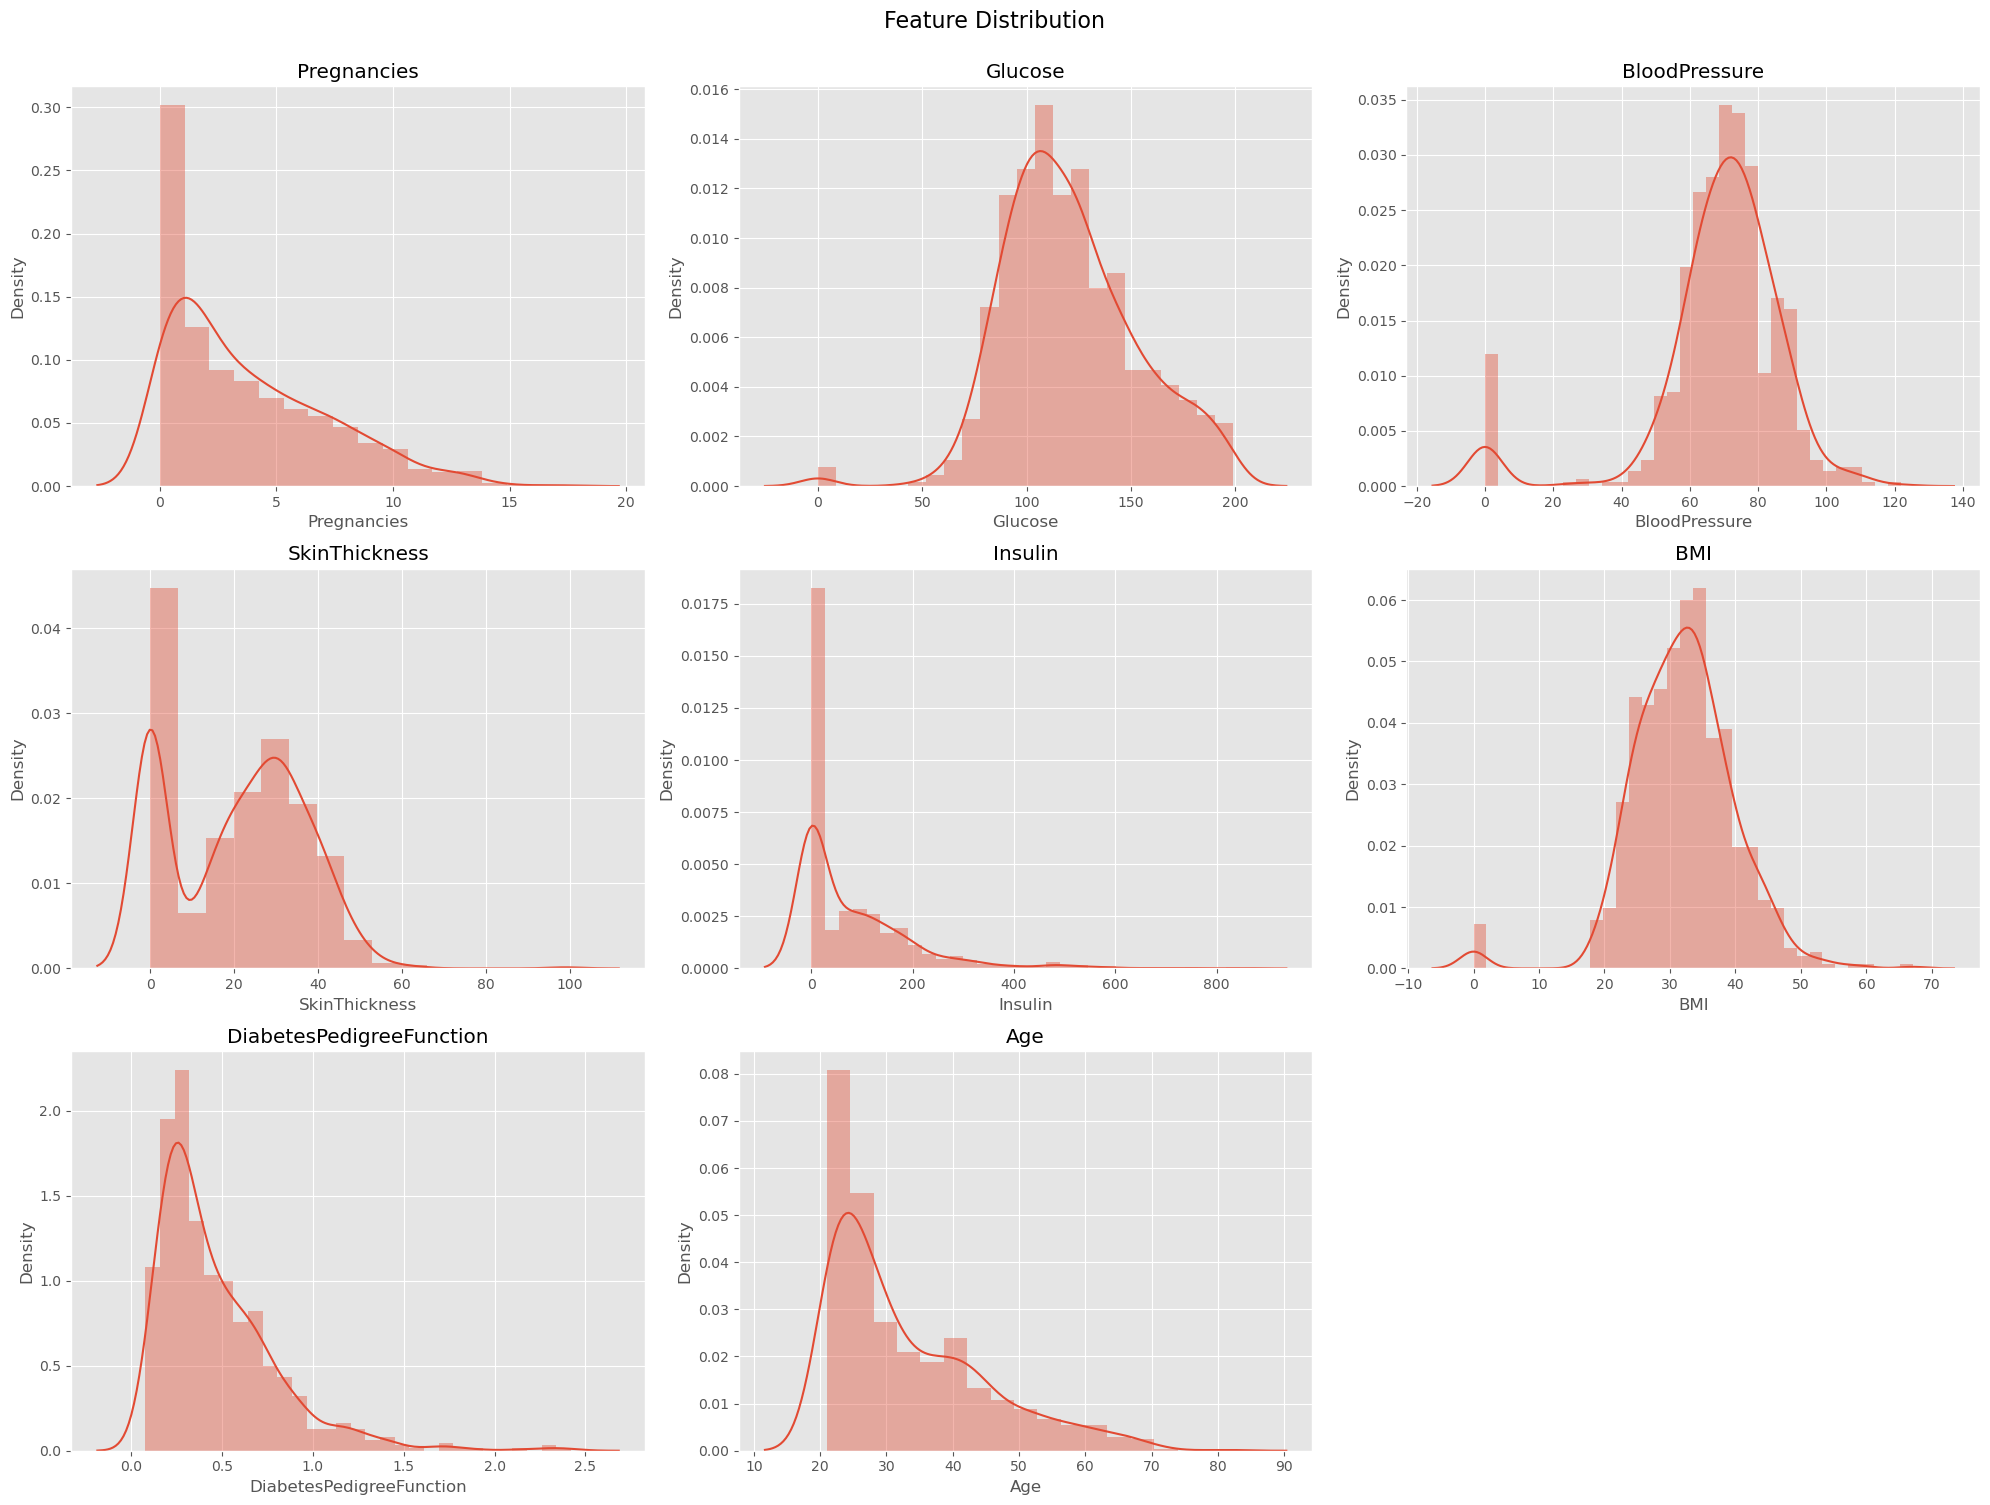

In [84]:
# Check for distribution of dataset
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten()

for (idx, col) in enumerate(data.columns[:-1]):
    distplot = sns.distplot(data[col], ax=axes[idx])
    distplot.set_title(col)

# Delete remaining axes
for r_a in axes[len(data.columns[:-1]):]:
    fig.delaxes(r_a)

# Add subtitle
fig.suptitle("Feature Distribution", fontsize=16, y=1)
plt.tight_layout()
plt.show()

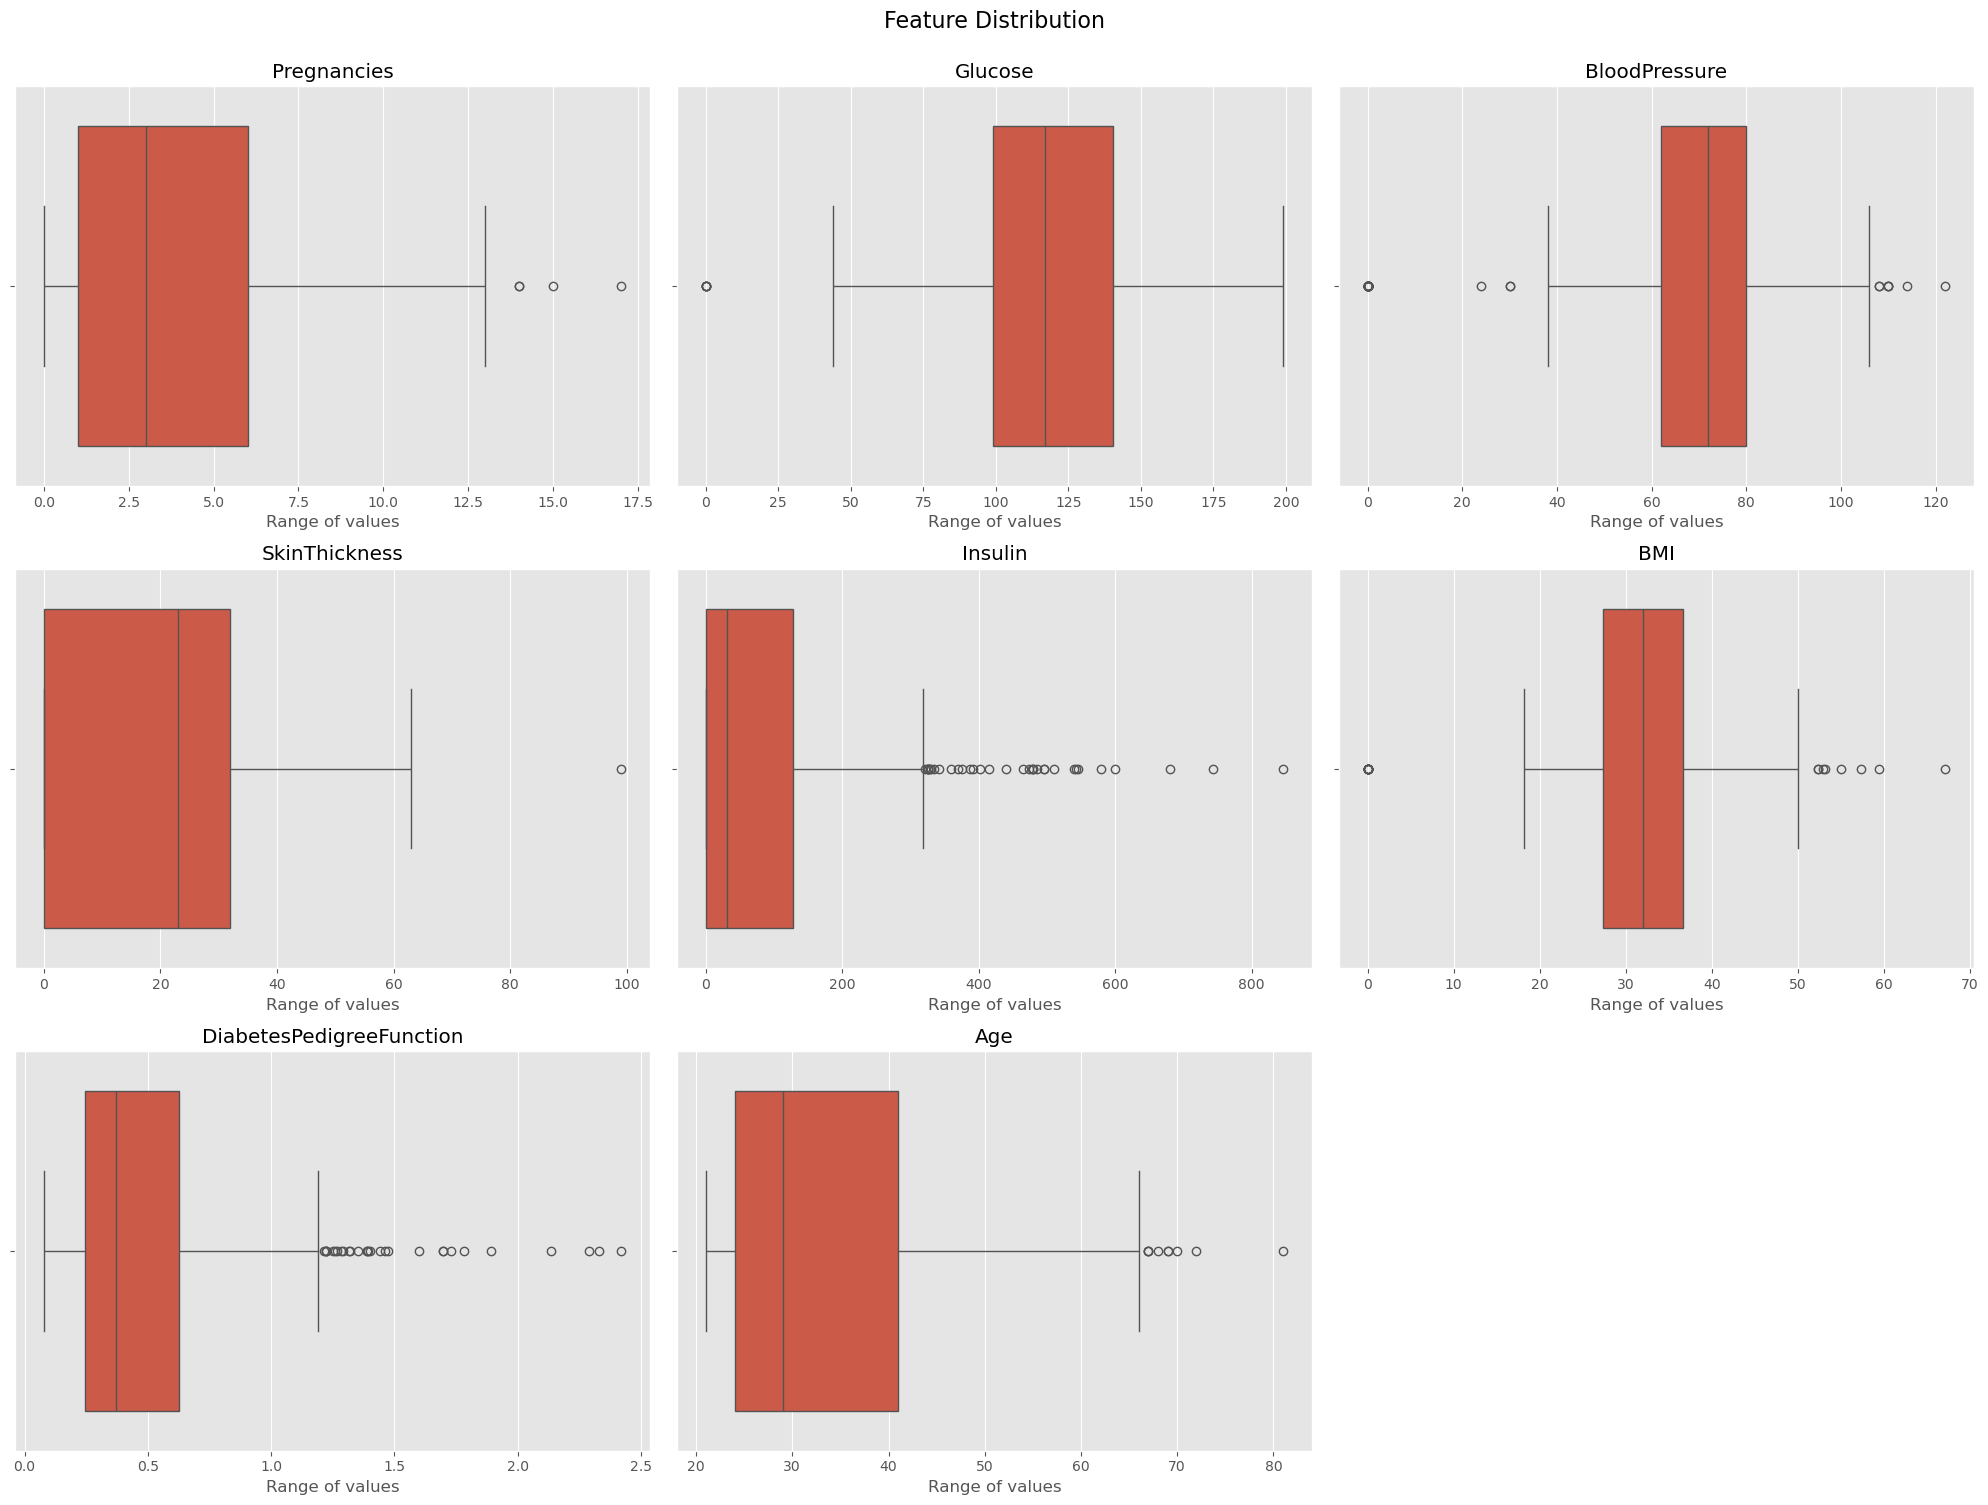

In [85]:
# Check for distribution of dataset
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten()

for (idx, col) in enumerate(data.columns[:-1]):
    boxplot = sns.boxplot(x=data[col], ax=axes[idx])
    boxplot.set_title(col)
    boxplot.set_xlabel("Range of values")

# Delete remaining axes
for r_a in axes[len(data.columns[:-1]):]:
    fig.delaxes(r_a)

# Add subtitle
fig.suptitle("Feature Distribution", fontsize=16, y=1)
plt.tight_layout()
plt.show()

### Column transformation

In [86]:
ztransformed_data = data.iloc[:, :-1].apply(zscore) # z - transform

### Train Test Split

In [87]:
from sklearn.model_selection import train_test_split

xtrain_1, xtest_1, ytrain_1, ytest_1 = train_test_split(ztransformed_data,
                                                        data["Outcome"],
                                                        test_size=0.1,
                                                        stratify=data["Outcome"],
                                                        random_state=0)

### Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(xtrain_1, ytrain_1)

LogisticRegression()

### Model Evaluation

In [89]:
lr_pred = lr.predict(xtest_1)

print(f"LogisticRegression accuracy score: {accuracy_score(ytest_1, lr_pred) * 100:.1f}%")

LogisticRegression accuracy score: 81.8%


In [90]:
# Save model

joblib.dump(lr, "LogisticRegressionModel.pkl")

['LogisticRegressionModel.pkl']

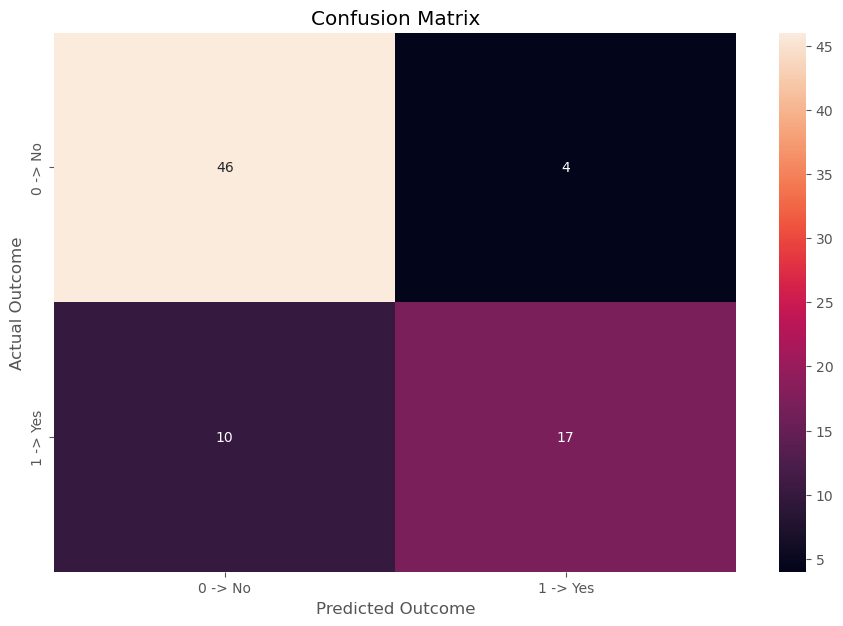

In [91]:
# Confusion matrix
plt.figure(figsize=(11, 7))
heatmap = sns.heatmap(confusion_matrix(ytest_1, lr_pred), annot=True)
heatmap.set_xticklabels(["0 -> No", "1 -> Yes"])
heatmap.set_yticklabels(["0 -> No", "1 -> Yes"])
heatmap.set_title("Confusion Matrix")
heatmap.set_xlabel("Predicted Outcome")
heatmap.set_ylabel("Actual Outcome")
plt.show()

In [92]:
def plot_roc_curve(fpr, tpr, roc_score):
    plt.figure(figsize=(15, 8))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC: {roc_score}")
    plt.show()

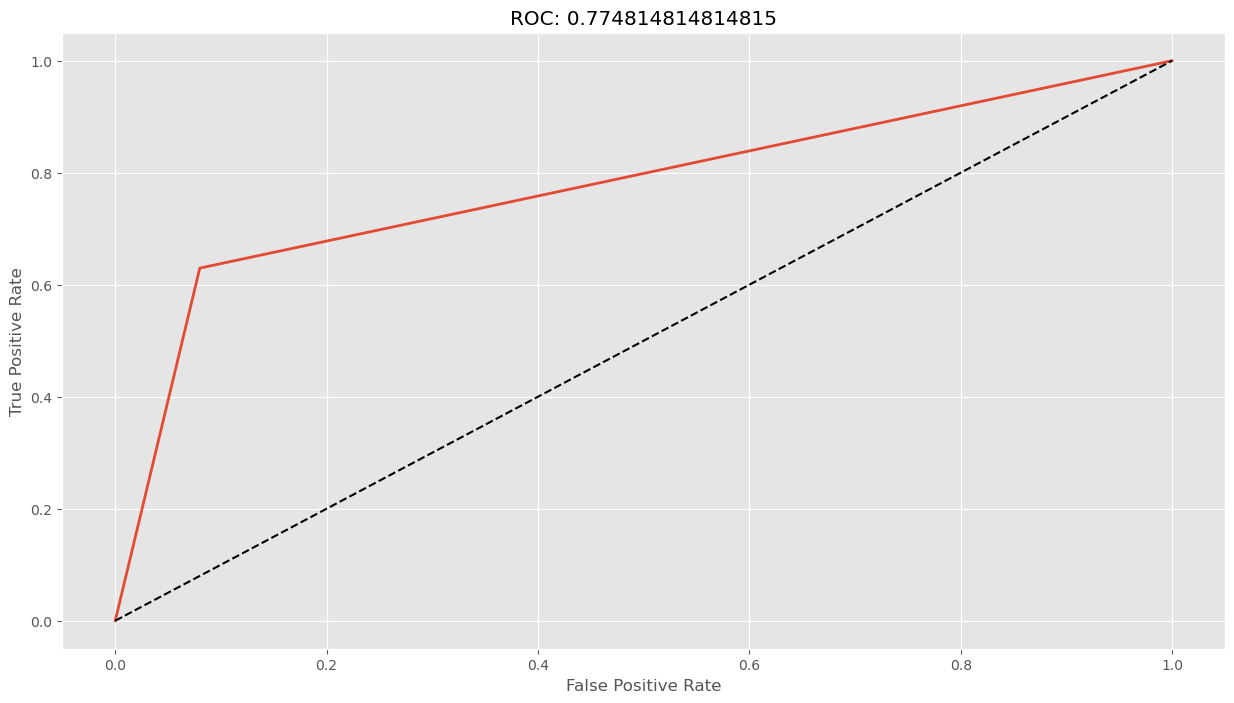

In [93]:
# ROC PLOT
roc_1 = roc_auc_score(ytest_1, lr_pred)

fpr_1, tpr_1, thresholds_1 = roc_curve(ytest_1, lr_pred)

plot_roc_curve(fpr_1, tpr_1, roc_1)

In [94]:
print("\t\t\tClassification report\n", classification_report(ytest_1, lr_pred))

			Classification report
               precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.81      0.63      0.71        27

    accuracy                           0.82        77
   macro avg       0.82      0.77      0.79        77
weighted avg       0.82      0.82      0.81        77



### GaussianNB

In [95]:
from sklearn.naive_bayes import GaussianNB

GN = GaussianNB()

GN.fit(xtrain_1, ytrain_1)

GaussianNB()

In [96]:
GN_pred = GN.predict(xtest_1)

print(f"GaussianNB accuracy score: {accuracy_score(ytest_1, GN_pred) * 100:.1f}%")

GaussianNB accuracy score: 81.8%


In [97]:
# Save model

joblib.dump(GN, "GaussianNBModel.pkl")

['GaussianNBModel.pkl']

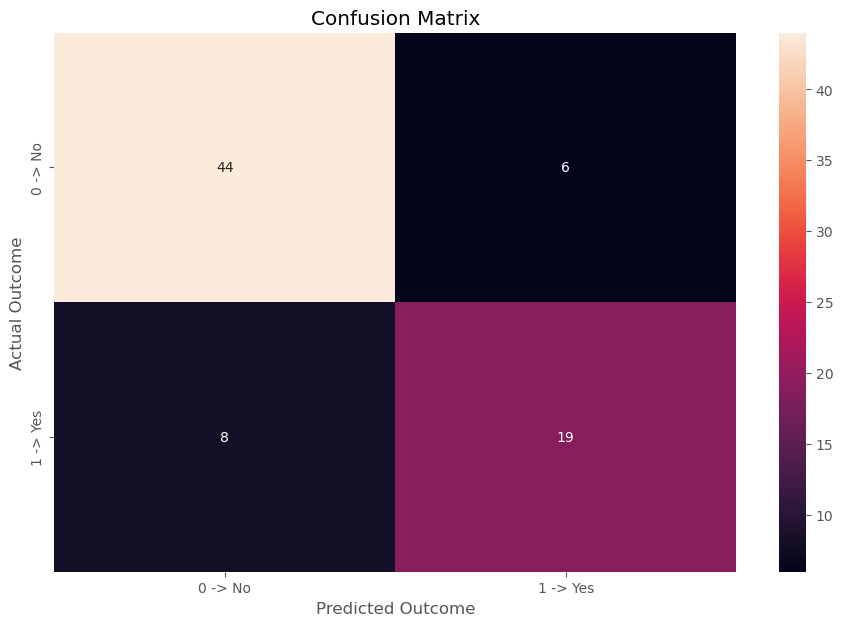

In [98]:
# Confusion matrix
plt.figure(figsize=(11, 7))
heatmap = sns.heatmap(confusion_matrix(ytest_1, GN_pred), annot=True)
heatmap.set_xticklabels(["0 -> No", "1 -> Yes"])
heatmap.set_yticklabels(["0 -> No", "1 -> Yes"])
heatmap.set_title("Confusion Matrix")
heatmap.set_xlabel("Predicted Outcome")
heatmap.set_ylabel("Actual Outcome")
plt.show()

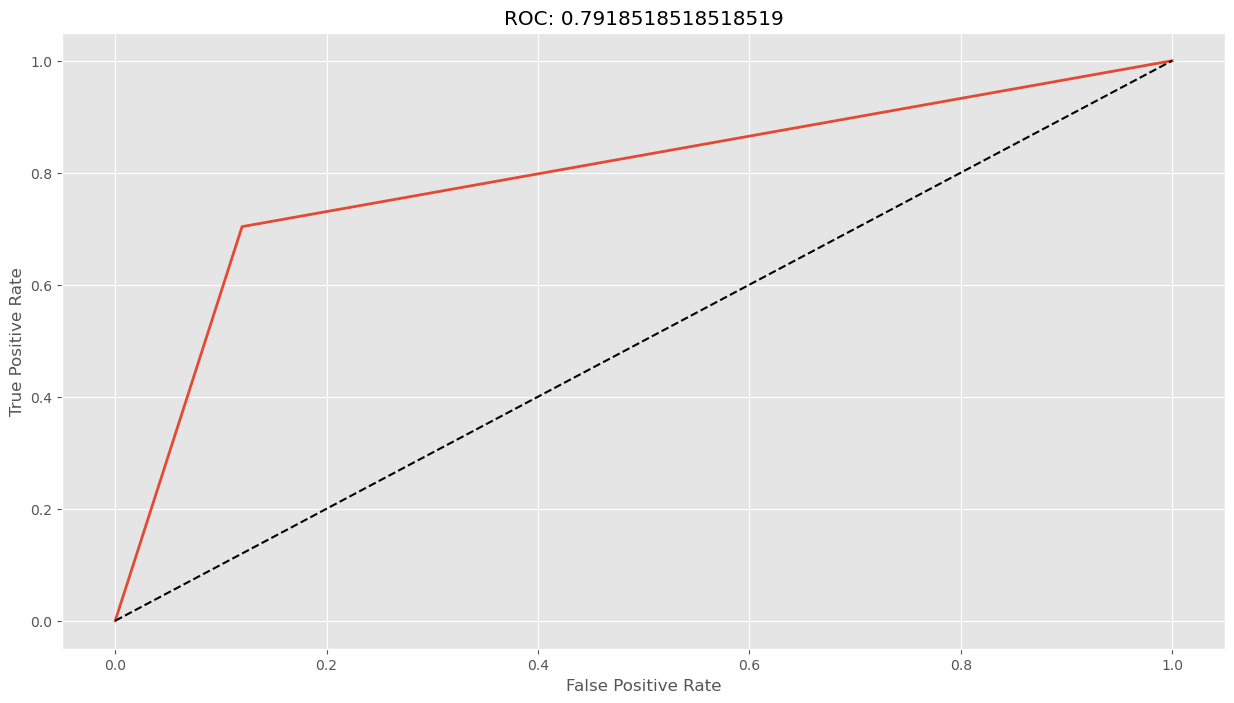

In [99]:
# ROC PLOT
roc_2 = roc_auc_score(ytest_1, GN_pred)

fpr_2, tpr_2, thresholds_2 = roc_curve(ytest_1, GN_pred)

plot_roc_curve(fpr_2, tpr_2, roc_2)

In [100]:
print("\t\t\tClassification report\n", classification_report(ytest_1, GN_pred))

			Classification report
               precision    recall  f1-score   support

           0       0.85      0.88      0.86        50
           1       0.76      0.70      0.73        27

    accuracy                           0.82        77
   macro avg       0.80      0.79      0.80        77
weighted avg       0.82      0.82      0.82        77



### Support vector machine

In [101]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(xtrain_1, ytrain_1)

SVC()

In [102]:
sv_pred = svc.predict(xtest_1)

print(f"SVC accuracy score: {accuracy_score(ytest_1, sv_pred) * 100:.1f}%")

SVC accuracy score: 80.5%


In [103]:
# Save model

joblib.dump(svc, "SVCModel.pkl")

['SVCModel.pkl']

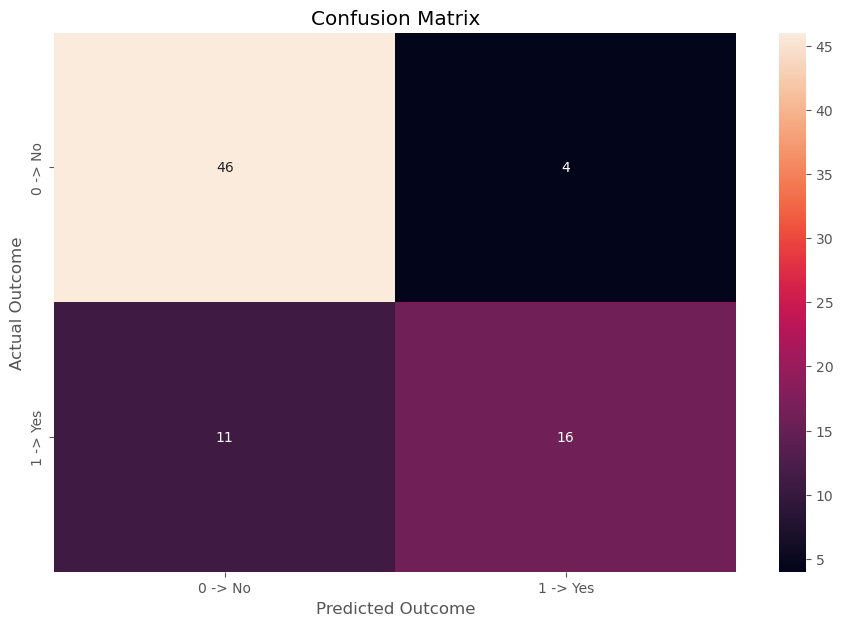

In [104]:
# Confusion matrix
plt.figure(figsize=(11, 7))
heatmap = sns.heatmap(confusion_matrix(ytest_1, sv_pred), annot=True)
heatmap.set_xticklabels(["0 -> No", "1 -> Yes"])
heatmap.set_yticklabels(["0 -> No", "1 -> Yes"])
heatmap.set_title("Confusion Matrix")
heatmap.set_xlabel("Predicted Outcome")
heatmap.set_ylabel("Actual Outcome")
plt.show()

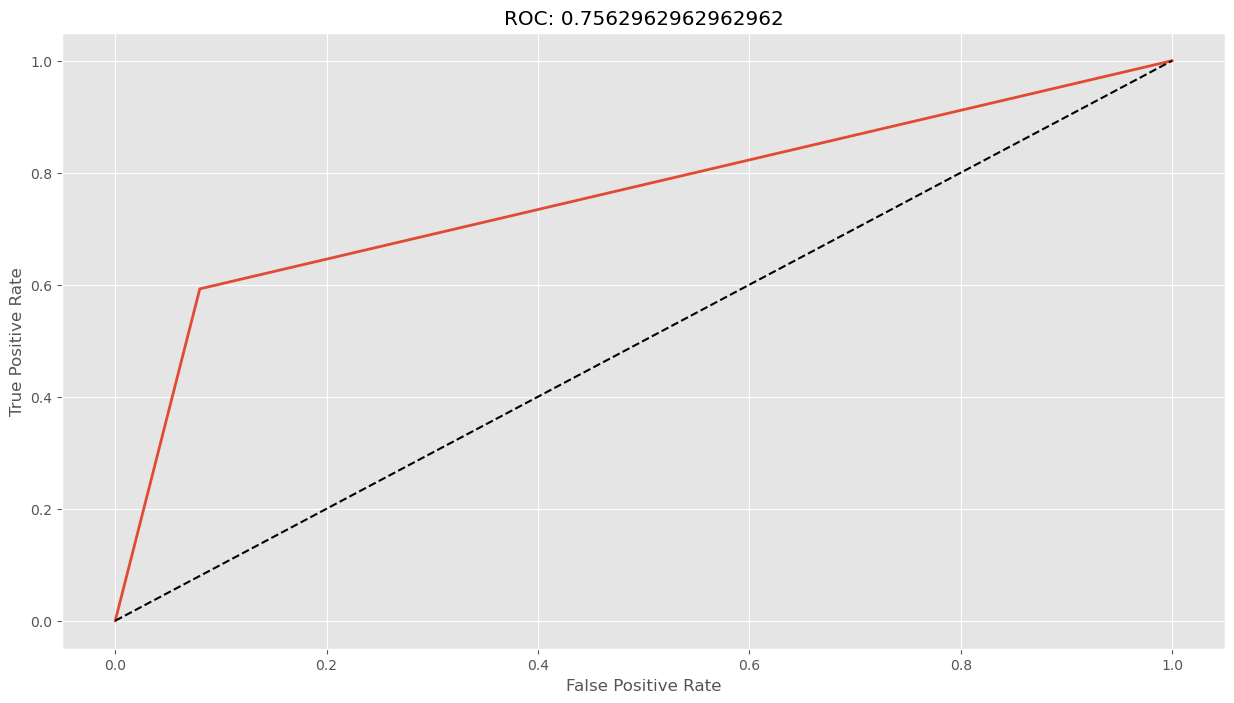

In [105]:
# ROC PLOT
roc_3 = roc_auc_score(ytest_1, sv_pred)

fpr_3, tpr_3, thresholds_3 = roc_curve(ytest_1, sv_pred)

plot_roc_curve(fpr_3, tpr_3, roc_3)

In [106]:
print("\t\t\tClassification report\n", classification_report(ytest_1, sv_pred))

			Classification report
               precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.80      0.59      0.68        27

    accuracy                           0.81        77
   macro avg       0.80      0.76      0.77        77
weighted avg       0.80      0.81      0.80        77



### K-Neighbour

In [107]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(xtrain_1, ytrain_1)

KNeighborsClassifier()

In [108]:
knn_pred = knn.predict(xtest_1)

print(f"KNeighborsClassifier accuracy score: {accuracy_score(ytest_1, knn_pred) * 100:.1f}%")

KNeighborsClassifier accuracy score: 79.2%


In [109]:
# Save model

joblib.dump(knn, "KNeighboursClassifierModel.pkl")

['KNeighboursClassifierModel.pkl']

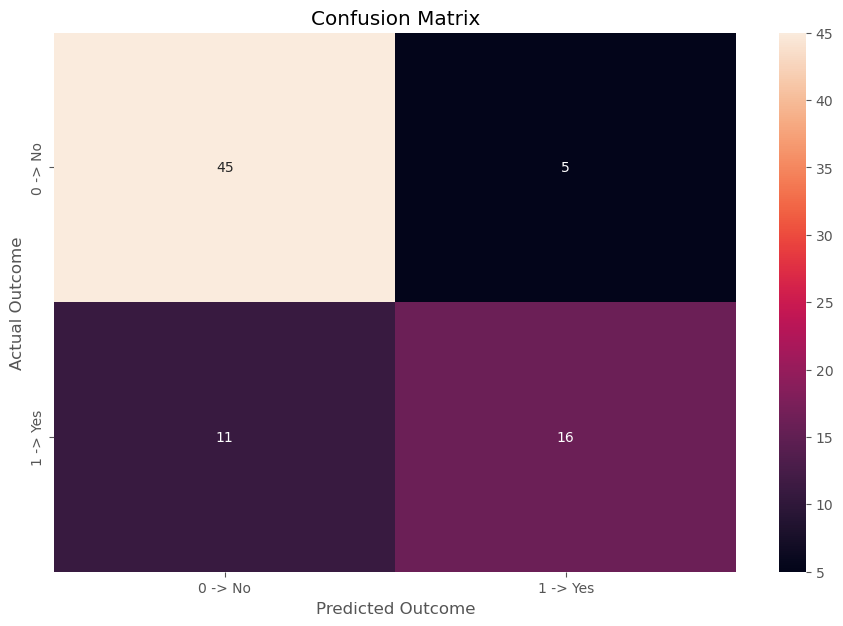

In [110]:
# Confusion matrix
plt.figure(figsize=(11, 7))
heatmap = sns.heatmap(confusion_matrix(ytest_1, knn_pred), annot=True)
heatmap.set_xticklabels(["0 -> No", "1 -> Yes"])
heatmap.set_yticklabels(["0 -> No", "1 -> Yes"])
heatmap.set_title("Confusion Matrix")
heatmap.set_xlabel("Predicted Outcome")
heatmap.set_ylabel("Actual Outcome")
plt.show()

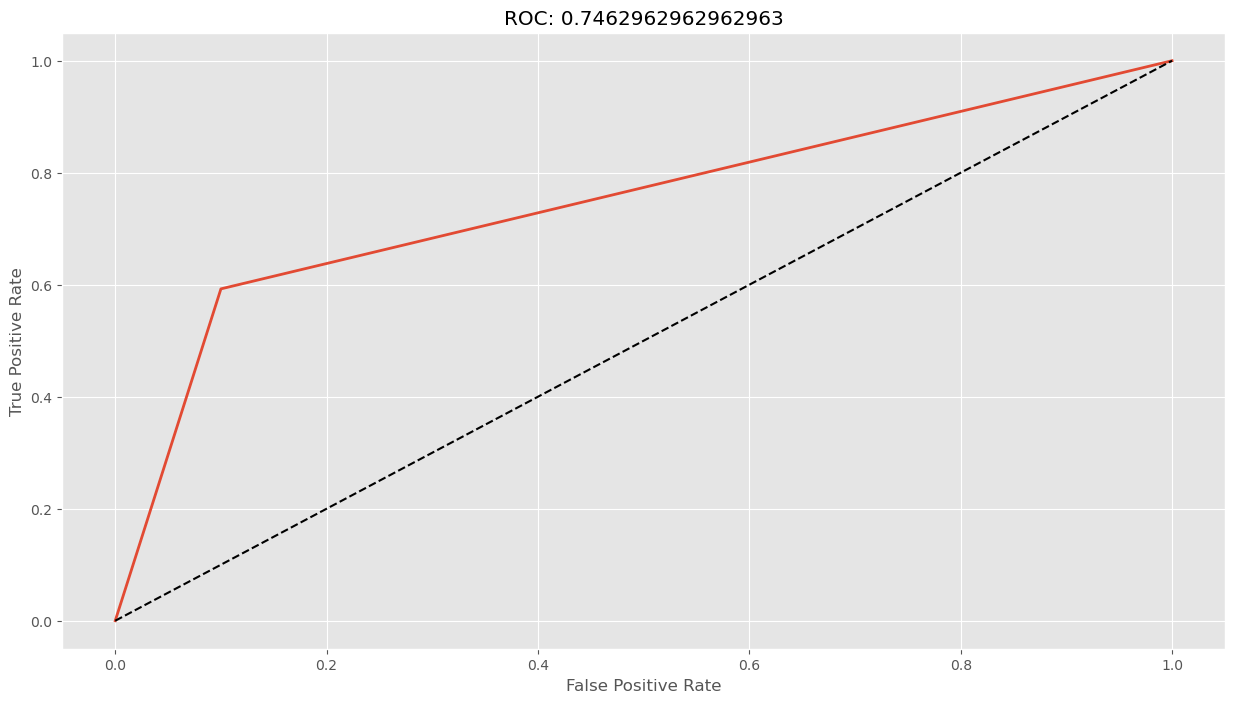

In [111]:
# ROC PLOT
roc_4 = roc_auc_score(ytest_1, knn_pred)

fpr_4, tpr_4, thresholds_4 = roc_curve(ytest_1, knn_pred)

plot_roc_curve(fpr_4, tpr_4, roc_4)

In [112]:
print("\t\t\tClassification report\n", classification_report(ytest_1, knn_pred))

			Classification report
               precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.76      0.59      0.67        27

    accuracy                           0.79        77
   macro avg       0.78      0.75      0.76        77
weighted avg       0.79      0.79      0.79        77



### Parameter optimization

In [113]:
### Parameter optimization using optuna

import optuna
from functools import partial
from sklearn.model_selection import KFold

def Objective(trials, X, y):
    param_kf = {"n_splits":trials.suggest_int("n_splits", 2, 10)}
    params_knn = {
        "n_neighbors":trials.suggest_int("n_neighbors", 1, 50),
        "weights":trials.suggest_categorical("weights", ['uniform', 'distance'])
    }
    knn = KNeighborsClassifier(**params_knn)
    kf = KFold(**param_kf)

    score = []

    for i, j in enumerate(kf.split(X, y)):
        xtrain, xtest = X.loc[j[0]], X.loc[j[1]]
        ytrain, ytest = y.iloc[j[0]], y.iloc[j[1]]

        knn.fit(xtrain, ytrain)

        val_pred = knn.predict(xtest)

        score.append(accuracy_score(ytest ,val_pred))

    return np.mean(score)

partial_func = partial(Objective, X=ztransformed_data, y=data["Outcome"])

study = optuna.create_study(direction="maximize")

study.optimize(partial_func, n_trials=20)

[I 2024-02-01 19:55:23,636] A new study created in memory with name: no-name-23bef18c-49e9-4525-97d9-d5dbb6f3ef46
[I 2024-02-01 19:55:23,693] Trial 0 finished with value: 0.7643229166666666 and parameters: {'n_splits': 2, 'n_neighbors': 20, 'weights': 'distance'}. Best is trial 0 with value: 0.7643229166666666.
[I 2024-02-01 19:55:23,815] Trial 1 finished with value: 0.7540212081496486 and parameters: {'n_splits': 7, 'n_neighbors': 18, 'weights': 'distance'}. Best is trial 0 with value: 0.7643229166666666.
[I 2024-02-01 19:55:24,068] Trial 2 finished with value: 0.7486979166666666 and parameters: {'n_splits': 6, 'n_neighbors': 44, 'weights': 'uniform'}. Best is trial 0 with value: 0.7643229166666666.
[I 2024-02-01 19:55:24,276] Trial 3 finished with value: 0.7604237867395762 and parameters: {'n_splits': 10, 'n_neighbors': 20, 'weights': 'distance'}. Best is trial 0 with value: 0.7643229166666666.
[I 2024-02-01 19:55:24,545] Trial 4 finished with value: 0.7500531995744034 and parameters

In [114]:
from sklearn.neighbors import KNeighborsClassifier

score = []

kf = KFold(n_splits=study.best_params["n_splits"])
target = data["Outcome"]
knn = KNeighborsClassifier(n_neighbors=study.best_params["n_neighbors"], weights=study.best_params["weights"])

for i, j in enumerate(kf.split(ztransformed_data, target)):
    xtrain, xtest = ztransformed_data.loc[j[0]], ztransformed_data.loc[j[1]]
    ytrain, ytest = target.iloc[j[0]], target.iloc[j[1]]

    knn.fit(xtrain, ytrain)

    val_pred = knn.predict(xtest)

    score.append(accuracy_score(ytest ,val_pred))

print("Accuracy score:", np.mean(score))

Accuracy score: 0.7643229166666666
